<ipython-input-26-67cda08dc0c8>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  travel_time_df["trip_start_time"]=travel_time_df["trip_start_minute"]+travel_time_df["trip_start_hour"]
<ipython-input-26-67cda08dc0c8>:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  travel_time_df["seconds_per_mile"]=cleaned_df["trip_seconds"]/cleaned_df["trip_miles"]


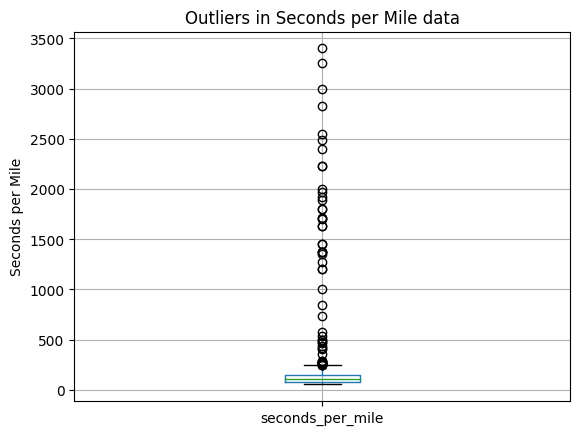

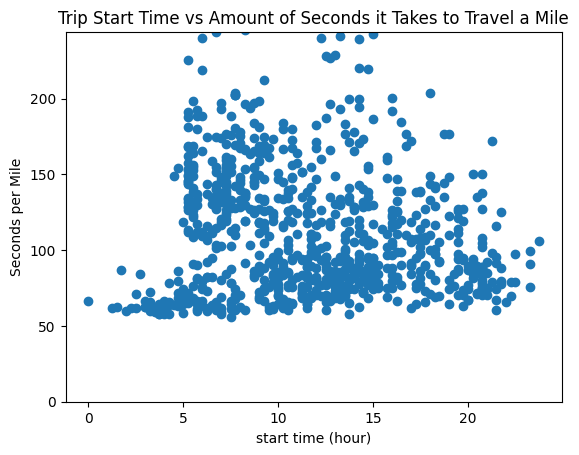

In [ ]:
#Entire code combined into one code block (into seperate blocks below)

#imported libraries
import pandas as pd
import matplotlib.pylab as plt
#create a dataframe with only the information relavent to are inqueries (cleaned)

#break up time stamp into year, month, day, hours, and minutes
def create_year_and_timestamp(timestamp,days,months,years,hours,minutes):
  timestamp_seperate=timestamp.split('T')
  #seperate date and turn into numbers
  date=timestamp_seperate[0]
  date=date.split('-')
  year=int(date[0])
  month=int(date[1])
  day=int(date[2])
  #seperate time and turn into numbers
  time=timestamp_seperate[1]
  time=time.split(':')
  hour=int(time[0])
  minute=int(time[1])
  #restrict dataset to only between 2022-2023
  if year>=2022 and year<=2023:
    days+=[day]
    months+=[month]
    years+=[year]
    hours+=[hour]
    minutes+=[minute]
    return (days,months,years,hours,minutes)
  else:
    return

#create a dataframe with only the columns we will be evaluating (trip_start_timestamp,trip_seconds,trip_miles,pickup_centroid_location,dropoff_centroid_location)
def create_dataframe(pd):
  #original data (csv) of chicago taxis
  greater_df=pd.read_csv("https://data.cityofchicago.org/resource/wrvz-psew.csv?$query=SELECT%20trip_id%2C%20taxi_id%2C%20trip_start_timestamp%2C%20trip_end_timestamp%2C%20trip_seconds%2C%20trip_miles%2C%20pickup_census_tract%2C%20dropoff_census_tract%2C%20pickup_community_area%2C%20dropoff_community_area%2C%20fare%2C%20tips%2C%20tolls%2C%20extras%2C%20trip_total%2C%20payment_type%2C%20company%2C%20pickup_centroid_latitude%2C%20pickup_centroid_longitude%2C%20pickup_centroid_location%2C%20dropoff_centroid_latitude%2C%20dropoff_centroid_longitude%2C%20dropoff_centroid_location%20ORDER%20BY%20pickup_centroid_latitude%20ASC")
  #create dataframe with only wanted columns
  cleaned_df=greater_df[["trip_start_timestamp","trip_seconds","trip_miles","pickup_centroid_location","dropoff_centroid_location"]]
  #remove any rows that are missing one of the columns
  cleaned_df=cleaned_df.dropna()
  #remove rows that aren't from 2022 or 2023
  timestamps=cleaned_df["trip_start_timestamp"].to_list()
  #count rows
  row_number=-1
  days=[]
  months=[]
  years=[]
  hours=[]
  minutes=[]
  for timestamp in timestamps:
    row_number+=1
    try:
      days,months,years,hours,minutes=create_year_and_timestamp(timestamp,days,months,years,hours,minutes)
    except:
      #remove rows that aren't from 2022-2023
      cleaned_df=cleaned_df.drop([row_number])

  #reset the row number in the dataframe after the removal of rows
  cleaned_df=cleaned_df.reset_index(drop=True)
  #replace timestamp column with individual columns for day, month, year, hour, and minute to make it easier to operate on
  cleaned_df["trip_start_day"]=days
  cleaned_df["trip_start_month"]=months
  cleaned_df["trip_start_year"]=years
  cleaned_df["trip_start_hour"]=hours
  cleaned_df["trip_start_minute"]=minutes
  cleaned_df=cleaned_df.drop(["trip_start_timestamp"], axis=1)
  #finished dataframe
  return cleaned_df

#initate creating a dataframe with only the information relavent to are inqueries (cleaned)
cleaned_df=create_dataframe(pd)
#display
print(cleaned_df)

#creating a plot to see the change in amount of time it takes to travel based on the time of day the trip starts

def transform_hours_and_minutes(cleaned_df):
  #mintues converted into fractions of an hour (15min=0.25hr etc.)
  cleaned_df["trip_start_minute"]=cleaned_df["trip_start_minute"].replace(to_replace=15, value=0.25)
  cleaned_df["trip_start_minute"]=cleaned_df["trip_start_minute"].replace(to_replace=30, value=0.5)
  cleaned_df["trip_start_minute"]=cleaned_df["trip_start_minute"].replace(to_replace=45, value=0.75)
  #new df created for travel time
  travel_time_df=cleaned_df[["trip_start_minute","trip_start_hour"]]
  #make a combined hour and minutes column
  travel_time_df["trip_start_time"]=travel_time_df["trip_start_minute"]+travel_time_df["trip_start_hour"]
  #return the new dataframe
  return travel_time_df

#find the min and max of a set of data while excluding outliers
def find_lims(any_dataframe_column):
  #find the IQR to calculate the MIN and MAX
  firstQ=any_dataframe_column.quantile(0.25)
  thirdQ=any_dataframe_column.quantile(0.75)
  IQR=thirdQ-firstQ
  #find the MIN and MAX
  MAX=thirdQ+(1.5*IQR)
  MIN=firstQ-(1.5*IQR)
  #return min and max
  return MAX, MIN

def travel_time_plot(cleaned_df,pd,plt):
  #make new dataframe so that editing of columns is not reflected in the original data
  #edit time (hours and minutes) so that it is one column with mintues converted into fractions of an hour (15min=0.25hr etc.)
  travel_time_df=transform_hours_and_minutes(cleaned_df)
  #create new column of the amount of time it takes to cover one mile
  travel_time_df["seconds_per_mile"]=cleaned_df["trip_seconds"]/cleaned_df["trip_miles"]
  #create boxplot to see outliers of seconds per mile
  travel_time_df.boxplot(column=["seconds_per_mile"])
  plt.title("Outliers in Seconds per Mile data")
  plt.ylabel("Seconds per Mile")
  plt.show()
  #find limits (exclude outliers) of the seconds per mile column
  YMAX, YMIN=find_lims(travel_time_df["seconds_per_mile"])
  #make a scatter plot of start time (hour) vs seconds per mile - excluded outliers from seconds per mile
  plt.scatter(travel_time_df["trip_start_time"],travel_time_df["seconds_per_mile"])
  #exclude outliers from seconds per mile
  if YMIN>=0:
    plt.ylim(YMIN,YMAX)
  else:
    plt.ylim(0,YMAX)
  #title and axis labels
  plt.title("Trip Start Time vs Amount of Seconds it Takes to Travel a Mile")
  plt.ylabel("Seconds per Mile")
  plt.xlabel("start time (hour)")
  #display scatter plot
  plt.show()

#initate creating a plot to see the change in amount of time it takes to travel based on the time of day the trip starts
travel_time_plot(cleaned_df,pd,plt)


In [ ]:
#create a dataframe with only the information relavent to are inqueries (cleaned)
#imported libraries
import pandas as pd
import matplotlib.pylab as plt

#break up time stamp into year, month, day, hours, and minutes
def create_year_and_timestamp(timestamp,days,months,years,hours,minutes):
  timestamp_seperate=timestamp.split('T')
  #seperate date and turn into numbers
  date=timestamp_seperate[0]
  date=date.split('-')
  year=int(date[0])
  month=int(date[1])
  day=int(date[2])
  #seperate time and turn into numbers
  time=timestamp_seperate[1]
  time=time.split(':')
  hour=int(time[0])
  minute=int(time[1])
  #restrict dataset to only between 2022-2023
  if year>=2022 and year<=2023:
    days+=[day]
    months+=[month]
    years+=[year]
    hours+=[hour]
    minutes+=[minute]
    return (days,months,years,hours,minutes)
  else:
    return

#create a dataframe with only the columns we will be evaluating (trip_start_timestamp,trip_seconds,trip_miles,pickup_centroid_location,dropoff_centroid_location)
def create_dataframe(pd):
  #original data (csv) of chicago taxis
  greater_df=pd.read_csv("https://data.cityofchicago.org/resource/wrvz-psew.csv?$query=SELECT%20trip_id%2C%20taxi_id%2C%20trip_start_timestamp%2C%20trip_end_timestamp%2C%20trip_seconds%2C%20trip_miles%2C%20pickup_census_tract%2C%20dropoff_census_tract%2C%20pickup_community_area%2C%20dropoff_community_area%2C%20fare%2C%20tips%2C%20tolls%2C%20extras%2C%20trip_total%2C%20payment_type%2C%20company%2C%20pickup_centroid_latitude%2C%20pickup_centroid_longitude%2C%20pickup_centroid_location%2C%20dropoff_centroid_latitude%2C%20dropoff_centroid_longitude%2C%20dropoff_centroid_location%20ORDER%20BY%20pickup_centroid_latitude%20ASC")
  #create dataframe with only wanted columns
  cleaned_df=greater_df[["trip_start_timestamp","trip_seconds","trip_miles","pickup_centroid_location","dropoff_centroid_location"]]
  #remove any rows that are missing one of the columns
  cleaned_df=cleaned_df.dropna()
  #remove rows that aren't from 2022 or 2023
  timestamps=cleaned_df["trip_start_timestamp"].to_list()
  #count rows
  row_number=-1
  days=[]
  months=[]
  years=[]
  hours=[]
  minutes=[]
  for timestamp in timestamps:
    row_number+=1
    try:
      days,months,years,hours,minutes=create_year_and_timestamp(timestamp,days,months,years,hours,minutes)
    except:
      #remove rows that aren't from 2022-2023
      cleaned_df=cleaned_df.drop([row_number])

  #reset the row number in the dataframe after the removal of rows
  cleaned_df=cleaned_df.reset_index(drop=True)
  #replace timestamp column with individual columns for day, month, year, hour, and minute to make it easier to operate on
  cleaned_df["trip_start_day"]=days
  cleaned_df["trip_start_month"]=months
  cleaned_df["trip_start_year"]=years
  cleaned_df["trip_start_hour"]=hours
  cleaned_df["trip_start_minute"]=minutes
  cleaned_df=cleaned_df.drop(["trip_start_timestamp"], axis=1)
  #finished dataframe
  return cleaned_df

#initate creating a dataframe with only the information relavent to are inqueries (cleaned)
cleaned_df=create_dataframe(pd)
#display
print(cleaned_df)

<ipython-input-28-332e24eb1dad>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  travel_time_df["trip_start_time"]=travel_time_df["trip_start_minute"]+travel_time_df["trip_start_hour"]
<ipython-input-28-332e24eb1dad>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  travel_time_df["seconds_per_mile"]=cleaned_df["trip_seconds"]/cleaned_df["trip_miles"]


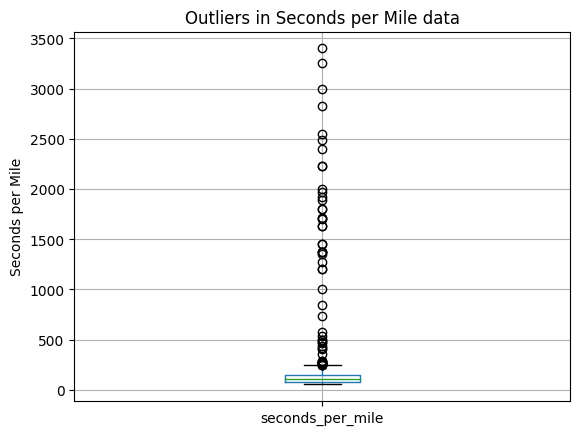

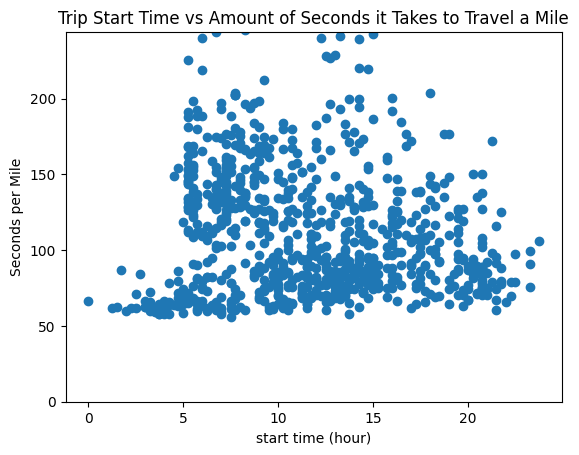

In [28]:
#creating a plot to see the change in amount of time it takes to travel based on the time of day the trip starts

def transform_hours_and_minutes(cleaned_df):
  #mintues converted into fractions of an hour (15min=0.25hr etc.)
  cleaned_df["trip_start_minute"]=cleaned_df["trip_start_minute"].replace(to_replace=15, value=0.25)
  cleaned_df["trip_start_minute"]=cleaned_df["trip_start_minute"].replace(to_replace=30, value=0.5)
  cleaned_df["trip_start_minute"]=cleaned_df["trip_start_minute"].replace(to_replace=45, value=0.75)
  #new df created for travel time
  travel_time_df=cleaned_df[["trip_start_minute","trip_start_hour"]]
  #make a combined hour and minutes column
  travel_time_df["trip_start_time"]=travel_time_df["trip_start_minute"]+travel_time_df["trip_start_hour"]
  #return the new dataframe
  return travel_time_df

#find the min and max of a set of data while excluding outliers
def find_lims(any_dataframe_column):
  #find the IQR to calculate the MIN and MAX
  firstQ=any_dataframe_column.quantile(0.25)
  thirdQ=any_dataframe_column.quantile(0.75)
  IQR=thirdQ-firstQ
  #find the MIN and MAX
  MAX=thirdQ+(1.5*IQR)
  MIN=firstQ-(1.5*IQR)
  #return min and max
  return MAX, MIN

def travel_time_plot(cleaned_df,pd,plt):
  #make new dataframe so that editing of columns is not reflected in the original data
  #edit time (hours and minutes) so that it is one column with mintues converted into fractions of an hour (15min=0.25hr etc.)
  travel_time_df=transform_hours_and_minutes(cleaned_df)
  #create new column of the amount of time it takes to cover one mile
  travel_time_df["seconds_per_mile"]=cleaned_df["trip_seconds"]/cleaned_df["trip_miles"]
  #create boxplot to see outliers of seconds per mile
  travel_time_df.boxplot(column=["seconds_per_mile"])
  plt.title("Outliers in Seconds per Mile data")
  plt.ylabel("Seconds per Mile")
  plt.show()
  #find limits (exclude outliers) of the seconds per mile column
  YMAX, YMIN=find_lims(travel_time_df["seconds_per_mile"])
  #make a scatter plot of start time (hour) vs seconds per mile - excluded outliers from seconds per mile
  plt.scatter(travel_time_df["trip_start_time"],travel_time_df["seconds_per_mile"])
  #exclude outliers from seconds per mile
  if YMIN>=0:
    plt.ylim(YMIN,YMAX)
  else:
    plt.ylim(0,YMAX)
  #title and axis labels
  plt.title("Trip Start Time vs Amount of Seconds it Takes to Travel a Mile")
  plt.ylabel("Seconds per Mile")
  plt.xlabel("start time (hour)")
  #display scatter plot
  plt.show()

#initate creating a plot to see the change in amount of time it takes to travel based on the time of day the trip starts
travel_time_plot(cleaned_df,pd,plt)